**Import Required Libraries**

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')


__Load and Process Dataset__

In [3]:
# Unzip the dataset
zip_path = 'E:/Datasets/Crema.zip'
extracted_path = 'E:/Datasets/Crema'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Verify the files were extracted correctly
print(f"Files extracted: {len(os.listdir(extracted_path))}")

# Display a few of the filenames to understand the structure
for dirname, _, filenames in os.walk(extracted_path):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))


Files extracted: 7442
E:/Datasets/Crema\1001_DFA_ANG_XX.wav
E:/Datasets/Crema\1001_DFA_DIS_XX.wav
E:/Datasets/Crema\1001_DFA_FEA_XX.wav
E:/Datasets/Crema\1001_DFA_HAP_XX.wav
E:/Datasets/Crema\1001_DFA_NEU_XX.wav


__Classifying Dataset__

In [14]:
import os

# Paths to the dataset
extracted_path = 'E:/Datasets/Crema'

# Lists to store file paths and emotions
paths_crema = []
emotions_crema = []

# Walk through the directory
for dirname, _, filenames in os.walk(extracted_path):
    for filename in filenames:
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        
        # Store the file path
        paths_crema.append(full_path)
        
        # Extract emotion from the filename
        part = filename.split('_')
        if len(part) > 2:  # Ensure the filename is in the expected format
            emotion_code = part[2]
            if emotion_code == 'SAD':
                emotions_crema.append('sad')
            elif emotion_code == 'ANG':
                emotions_crema.append('angry')
            elif emotion_code == 'DIS':
                emotions_crema.append('disgust')
            elif emotion_code == 'FEA':
                emotions_crema.append('fear')
            elif emotion_code == 'HAP':
                emotions_crema.append('happy')
            elif emotion_code == 'NEU':
                emotions_crema.append('neutral')
            else:
                emotions_crema.append('Unknown')
        else:
            emotions_crema.append('Unknown')

# Print the number of files and some examples to verify
print(f"Number of files: {len(paths_crema)}")
print(f"Example file paths and emotions:")
for i in range(5):
    print(f"Path: {paths_crema[i]}, Emotion: {emotions_crema[i]}")


Number of files: 7442
Example file paths and emotions:
Path: E:/Datasets/Crema\1001_DFA_ANG_XX.wav, Emotion: angry
Path: E:/Datasets/Crema\1001_DFA_DIS_XX.wav, Emotion: disgust
Path: E:/Datasets/Crema\1001_DFA_FEA_XX.wav, Emotion: fear
Path: E:/Datasets/Crema\1001_DFA_HAP_XX.wav, Emotion: happy
Path: E:/Datasets/Crema\1001_DFA_NEU_XX.wav, Emotion: neutral


__Visualization of Dataset__

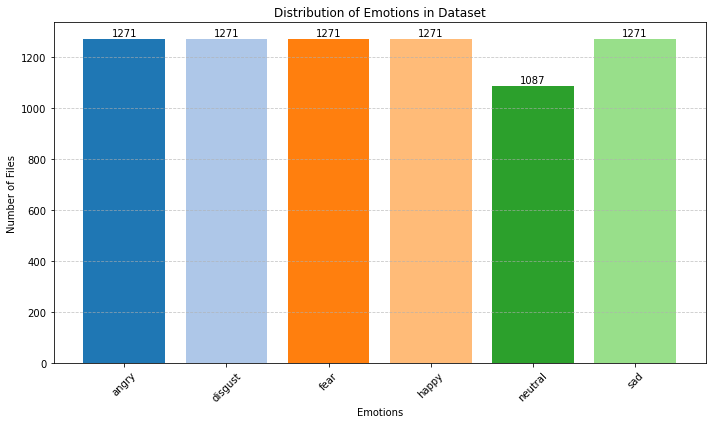

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences of each emotion
emotion_counts = Counter(emotions_crema)

# Extract labels and counts
labels, counts = zip(*emotion_counts.items())

# Define a color for each emotion (make sure you have enough colors for all unique emotions)
colors = plt.cm.tab20.colors  # You can use other colormaps or manually define a list of colors
color_map = {label: colors[i % len(colors)] for i, label in enumerate(labels)}

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=[color_map[label] for label in labels])

# Annotate each bar with the count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, int(height),
             ha='center', va='bottom')

plt.xlabel('Emotions')
plt.ylabel('Number of Files')
plt.title('Distribution of Emotions in Dataset')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


__Visualization of Waveform graphs of Emotions__

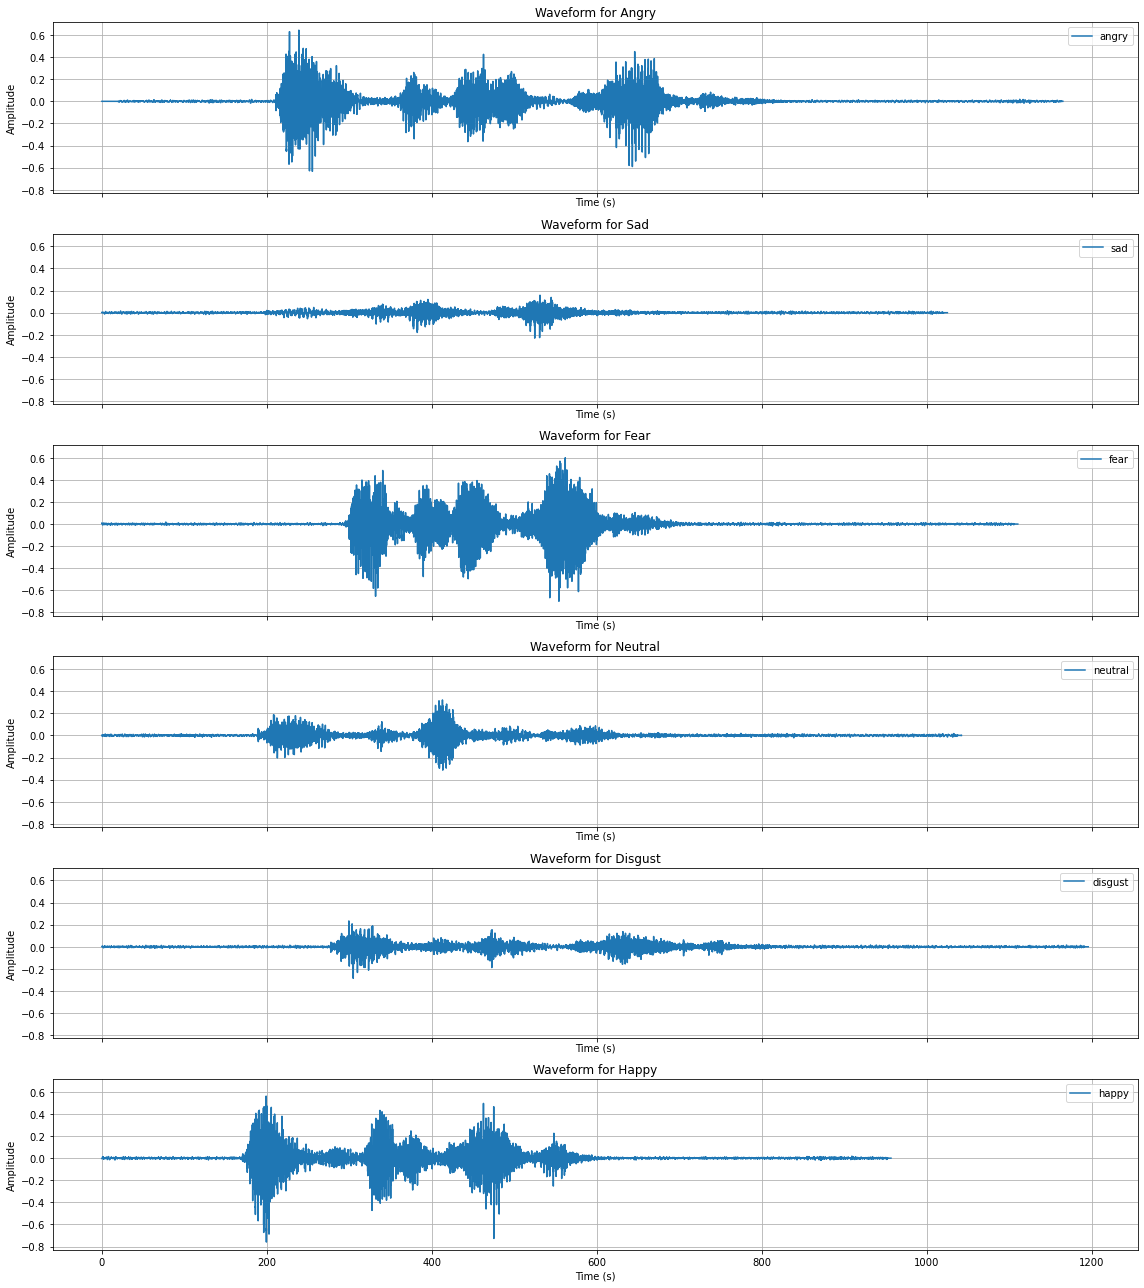

In [23]:
import librosa
import matplotlib.pyplot as plt
import os

# Initialize emotion categories and file paths
emotions_set = set(emotions_crema)
emotions_paths = {emotion: [] for emotion in emotions_set}

# Map file paths to emotions
for path, emotion in zip(paths_crema, emotions_crema):
    if emotion in emotions_paths:
        emotions_paths[emotion].append(path)

# Create a figure with adjusted size
fig, axes = plt.subplots(len(emotions_set), 1, figsize=(16, 18), sharex=True, sharey=True)

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5)

# Plot waveform for each emotion
for idx, (emotion, paths) in enumerate(emotions_paths.items()):
    if not paths:
        continue
    
    # Load the first file for each emotion
    file_path = paths[0]
    y, sr = librosa.load(file_path)
    
    # Generate the waveform
    ax = axes[idx]
    ax.plot(librosa.times_like(y, sr=sr), y, label=emotion)
    ax.set_title(f'Waveform for {emotion.capitalize()}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.legend(loc='upper right')

# Adjust layout to ensure there's enough space between subplots
plt.tight_layout()
plt.show()


__Feature Extraction__

In [11]:
import librosa
import numpy as np
import os

def extract_features(file_name):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_name, sr=None)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        
        # Extract Chroma features
        stft = np.abs(librosa.stft(audio))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        chroma_scaled = np.mean(chroma.T, axis=0)
        
        # Extract Mel-Spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_scaled = np.mean(mel.T, axis=0)
        
        # Extract Spectral Contrast
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        contrast_scaled = np.mean(contrast.T, axis=0)
        
        # Combine all features
        features = np.hstack([mfccs_scaled, chroma_scaled, mel_scaled, contrast_scaled])
        
        return features
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        print(e)
        return None

# Re-extract features
features = []
labels = []

for dirname, _, filenames in os.walk(extracted_path):
    for filename in filenames:
        if filename.endswith('.wav'):
            file_path = os.path.join(dirname, filename)
            emotion = filename.split('_')[2]  # Assuming emotion label is part of the filename
            data = extract_features(file_path)
            if data is not None:
                features.append(data)
                labels.append(emotion)

# Convert lists to numpy arrays
X = np.array(features)
y = np.array(labels)


__Encoding__ 

In [12]:
# Encode the labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_categorical = to_categorical(y_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Display the shape of the training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: (5953, 187)
Testing data shape: (1489, 187)
Training labels shape: (5953, 6)
Testing labels shape: (1489, 6)


__Model Building and Training__

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adam

# Reshape features for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build the CNN model
model = Sequential()
model.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(32, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


Epoch 1/50
187/187 [==============================] - 8s 38ms/step - loss: 1.8686 - accuracy: 0.2657 - val_loss: 1.5924 - val_accuracy: 0.3398
Epoch 2/50
187/187 [==============================] - 7s 40ms/step - loss: 1.5979 - accuracy: 0.3165 - val_loss: 1.5306 - val_accuracy: 0.3875
Epoch 3/50
187/187 [==============================] - 7s 38ms/step - loss: 1.5438 - accuracy: 0.3445 - val_loss: 1.4899 - val_accuracy: 0.4050
Epoch 4/50
187/187 [==============================] - 8s 42ms/step - loss: 1.5144 - accuracy: 0.3608 - val_loss: 1.4594 - val_accuracy: 0.3989
Epoch 5/50
187/187 [==============================] - 7s 38ms/step - loss: 1.4832 - accuracy: 0.3711 - val_loss: 1.4483 - val_accuracy: 0.4224
Epoch 6/50
187/187 [==============================] - 7s 39ms/step - loss: 1.4673 - accuracy: 0.3884 - val_loss: 1.4356 - val_accuracy: 0.4318
Epoch 7/50
187/187 [==============================] - 7s 39ms/step - loss: 1.4587 - accuracy: 0.3974 - val_loss: 1.4021 - val_accuracy: 0.4352

__Prediction on new sample__

In [19]:
import random

# Select a random audio file from the dataset
random_file = random.choice([os.path.join(dirname, filename) 
                             for dirname, _, filenames in os.walk(extracted_path) 
                             for filename in filenames if filename.endswith('.wav')])

# Display the selected file
print(f"Selected file: {random_file}")

# Extract features from the selected audio file
features = extract_features(random_file)

# Reshape the features for prediction
features = features.reshape(1, -1)

# Predict the emotion
predicted_emotion = model.predict(features)
predicted_emotion_label = label_encoder.inverse_transform([np.argmax(predicted_emotion)])

# Display the predicted emotion
print(f"Predicted Emotion: {predicted_emotion_label[0]}")


Selected file: E:/Datasets/Crema\1062_DFA_ANG_XX.wav
1/1 [==============================] - 0s 162ms/step
Predicted Emotion: ANG
